# Capstone Project - Training center location selection
### Applied Data Science Capstone by IBM/Coursera

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium.plugins import HeatMap

from bs4 import BeautifulSoup
import html5lib

print('Libraries imported.')

Libraries imported.


In [2]:
CLIENT_ID = 'TWQNBUQDQIII1KZJ0RTLFNG0NR15AVJIZU5KFPHM3ANEHMHU' # Foursquare ID
CLIENT_SECRET = 'VD0GO1D1LCR1T5GYDJHBVXS4REOQD4KVWSADZAZGKXOAQ1DU' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Getting latitude and longitude of Montreal

In [3]:
address = 'Montreal'

geolocator = Nominatim(user_agent="mtl_explorer")
location = geolocator.geocode(address)
latitude_mtl = location.latitude
longitude_mtl = location.longitude

## Search for Gym/Fitness venue categories in the Montreal area: 

In [4]:
gym_fitness = '4bf58dd8d48988d175941735' # Root id for all fitness and training facilities

categoryId = {'Boxing Gym':'52f2ab2ebcbc57f1066b8b47', 'Gym': '4bf58dd8d48988d176941735', 'Martial Arts School': '4bf58dd8d48988d101941735', 'Outdoor Gym': '58daa1558bbb0b01f18ec203'} # Category IDs for Boxing Gyms, Gyms, Martial Arts Dojos and outdoor gyms

radius = 26000 # Radius in which to search relative to the center of Montreal
LIMIT = 10000 # Limit of the number of venues to fetch

In [5]:
gym_df = pd.DataFrame()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Loop over the different category ids and search for the corresponding venues in the montreal area. Data will be stored in the gym_df dataframe:
for key_cat in categoryId:
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_mtl, longitude_mtl, VERSION, categoryId[key_cat], radius, LIMIT)

    results = requests.get(url).json()

    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)

    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    gym_df = gym_df.append(dataframe_filtered)

gym_df.drop_duplicates(subset='id', keep="last", inplace= True)
gym_df.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Club de Boxe de d'Est,Boxing Gym,2350 Rue Dickson,45.567281,-73.537101,"[{'label': 'display', 'lat': 45.56728097321409...",9668,H1N 3T1,CA,Montréal,QC,Canada,"[2350 Rue Dickson, Montréal QC H1N 3T1, Canada]",NaN,NaN,5241fdde11d28e28a9ad23c1
1,UnderDog Boxing Gym,Boxing Gym,9 Ste-Catherine East,45.510055,-73.563710,"[{'label': 'display', 'lat': 45.51005460345811...",3910,Ca,CA,Montréal,QC,Canada,"[9 Ste-Catherine East (St-Laurent), Montréal Q...",St-Laurent,NaN,4b6f9c10f964a520c6f72ce3
2,Hard Knox Boxing Gym,Boxing Gym,NaN,45.479412,-73.581359,"[{'label': 'display', 'lat': 45.47941243891546...",3008,NaN,CA,Montréal,QC,Canada,"[Montréal QC, Canada]",NaN,Le Sud-Ouest,51791840e4b0650bb54cbfc1
3,Académie Frontenac,Boxing Gym,2633 rue Ontario E,45.533786,-73.551749,"[{'label': 'display', 'lat': 45.53378607247854...",6121,H2K 1W8,CA,Montréal,QC,Canada,"[2633 rue Ontario E, Montréal QC H2K 1W8, Canada]",NaN,NaN,4d69203882cba093319bd6d8
4,apex,Boxing Gym,1827 St-Catherine W.,45.493524,-73.580149,"[{'label': 'display', 'lat': 45.493524, 'lng':...",2393,H3H 1M8,CA,Montréal,QC,Canada,"[1827 St-Catherine W. (St-Marc), Montréal QC H...",St-Marc,NaN,54ee76b3498ecc627d1df2a3


In [6]:
# Looking at the different venue categories obtained:
print('The querry fetched the following categories:')
for cat in gym_df['categories'].unique():
    print('- {}'.format(cat))

The querry fetched the following categories:
- Boxing Gym
- Gym
- Gym / Fitness Center
- Climbing Gym
- Residential Building (Apartment / Condo)
- Gym Pool
- Martial Arts School


In [7]:
# Making the categories more uniform:
gym_df.replace(to_replace = 'Gym / Fitness Center', value = 'Gym', inplace= True)

# Dropping dataframe rows that have a category that is non relevant for us:
for cat in gym_df['categories'].unique():
    if cat in categoryId.keys():
        pass
    else:
        gym_df = gym_df[gym_df['categories']!=cat]

# Looking at the different venue categories obtained:
print('The querry fetched the following categories:')
for cat in gym_df['categories'].unique():
    print('- {}'.format(cat))

The querry fetched the following categories:
- Boxing Gym
- Gym
- Martial Arts School


Text(0, 0.5, 'Frequency')

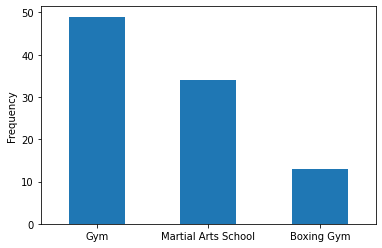

In [27]:
# Plot the frequency of each category:
gym_df['categories'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0)
plt.ylabel('Frequency')

In [8]:
# Color map to asociate a color for each category venue:
venue_colormap = {
    'Boxing Gym':'red', 
    'Gym': 'blue', 
    'Martial Arts School': 'black',
    'Outdoor Gym': 'yellow'
}

In [9]:
mtl_map = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)
for lat, lon, name, cat in zip(gym_df['lat'],gym_df['lng'], gym_df['name'], gym_df['categories']):
    label = '{}, ({})'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    try:
        color=venue_colormap[cat]
    except:
        color='grey'
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color = color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(mtl_map)

mtl_map

In [55]:
# Let us plot a heat map to better see the concentration of the trainings:
gym_latlng = [[lat,lng] for lat, lng in zip(list(gym_df['lat']),list(gym_df['lng']))]

mtl_heatmap = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)
folium.TileLayer('cartodbpositron').add_to(mtl_heatmap) #cartodbpositron cartodbdark_matter
HeatMap(gym_latlng).add_to(mtl_heatmap)
mtl_heatmap

### Explore the area around a specific venu (Test with YMCA):

In [23]:
# Building dataframe of gyms only:
gym_df = gym_mosque_df[gym_mosque_df['categories'] != 'Mosque']

NameError: name 'gym_mosque_df' is not defined

In [34]:
gym_df.shape

(97, 16)

In [9]:
len(gym_df['id'].unique())

97

In [11]:
gym_name = 'Tristar Gym'

# Getting the ID of the Gym of interest:
venue_id = list(gym_df.loc[gym_df['name']== gym_name]['id'])[0]# ID of Tristar

# Setting the url used to explore a specific venue (Limit is 500 calls per day):
gym_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

In [12]:
gym_results = requests.get(gym_url).json()

# assign relevant part of JSON to venues
venue = gym_results['response']

# tranform venues into a dataframe
dataframe = json_normalize(venue)


In [9]:
try:
    print('Likes count: {}'.format(gym_results['response']['venue']['likes']['count']))
except:
    print('Premium API calls limit reached')

try:
    print('Rating: {}'.format(gym_result['response']['venue']['rating']))
except:
    print('This venue has not been rated yet.')

Premium API calls limit reached
This venue has not been rated yet.


In [9]:
# We limit the serach to 100 venues in a 500m radius:
LIMIT = 100
radius = 1000

try:
    gym_latitude = gym_results['response']['venue']['location']['lat']
except:
    gym_latitude = list(gym_df.loc[gym_df['name']== gym_name]['lat'])[0]

try:
    gym_longitude = gym_results['response']['venue']['location']['lng']
except:
    gym_longitude = list(gym_df.loc[gym_df['name']== gym_name]['lng'])[0]

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, gym_latitude, gym_longitude, VERSION, radius, LIMIT)

NameError: name 'gym_name' is not defined

In [15]:
type(gym_latitude)

float

In [16]:
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.venuePage.id,venue.location.crossStreet
0,e-0-4be74c54cf200f47078c153c-0,0,"[{'summary': 'This spot is popular', 'type': '...",4be74c54cf200f47078c153c,Rib N Reef Steakhouse,8105 Décarie,45.498729,-73.659108,"[{'label': 'display', 'lat': 45.49872860816799...",135,H4P 2H5,CA,Montréal,QC,Canada,"[8105 Décarie, Montréal QC H4P 2H5, Canada]","[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",0,[],572577185,NaN
1,e-0-500f0584e4b0b5aafe9b7adf-1,0,"[{'summary': 'This spot is popular', 'type': '...",500f0584e4b0b5aafe9b7adf,Épicure,5252 Pare,45.496614,-73.654246,"[{'label': 'display', 'lat': 45.49661439087044...",316,H4P 1P5,CA,Montréal,QC,Canada,"[5252 Pare (Decarie), Montréal QC H4P 1P5, Can...","[{'id': '50be8ee891d4fa8dcc7199a7', 'name': 'M...",0,[],NaN,Decarie
2,e-0-4c1589307f7f2d7fd5b7e268-2,0,"[{'summary': 'This spot is popular', 'type': '...",4c1589307f7f2d7fd5b7e268,Kart-o-mania,5196 rue de la Savane,45.499451,-73.657526,"[{'label': 'display', 'lat': 45.4994514, 'lng'...",122,H4P 2M8,CA,Montréal,QC,Canada,"[5196 rue de la Savane, Montréal QC H4P 2M8, C...","[{'id': '52e81612bcbc57f1066b79ea', 'name': 'G...",0,[],NaN,NaN
3,e-0-4b17dbf9f964a520f5c823e3-3,0,"[{'summary': 'This spot is popular', 'type': '...",4b17dbf9f964a520f5c823e3,Gibeau Orange Julep,7700 boul. Décarie,45.495803,-73.656678,"[{'label': 'display', 'lat': 45.49580318786657...",290,H4P 2H4,CA,Montréal,QC,Canada,"[7700 boul. Décarie (coin Paré), Montréal QC H...","[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",0,[],NaN,coin Paré
4,e-0-4b099973f964a520231a23e3-4,0,"[{'summary': 'This spot is popular', 'type': '...",4b099973f964a520231a23e3,Bâton Rouge Steakhouse & Bar,5385 rue des Jockeys,45.494697,-73.655144,"[{'label': 'display', 'lat': 45.49469698379897...",444,H4P 2T8,CA,Montréal,QC,Canada,"[5385 rue des Jockeys, Montréal QC H4P 2T8, Ca...","[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",0,[],NaN,NaN


In [5]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

In [6]:

nearby_venues = nearby_venues[filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type,axis=1)

nearby_venues.columns = map(str.title,[col_name.split('.')[-1] for col_name in nearby_venues.columns])
nearby_venues.rename(columns={'Name':'Venue Name'}, inplace=True)

NameError: name 'nearby_venues' is not defined

In [15]:
# nearby_venues['Gym Name'] = 'Tristar'
# nearby_venues

## Nearby venues exploration for each gym:

In [12]:
# We define a function that regroups all the steps required to explore a specific venue and get its nearby venues:
 
def explore_gym_nearby_venues(gym_name, gym_cat, venue_id, gym_lat, gym_lng):
    # Setting the url used to explore a specific venue using the venue's id:
    gym_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

    gym_results = requests.get(gym_url).json()

    # Assign relevant part of JSON to venues
    venue = gym_results['response']

    # Tranform venues into a dataframe
    dataframe = json_normalize(venue)

    try:
        likes_count= gym_results['response']['venue']['likes']['count']
        # likes_count = dataframe['venue.likes.count'][0]
    except:
        likes_count = -1
        # likes_count = dataframe['venue.likes.count'][0]

    try:
        rating = gym_results['response']['venue']['rating']
        # rating = dataframe['venue.rating'][0]
    except:
        rating = -1
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, gym_lat, gym_lng, VERSION, radius, LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)

    nearby_venues = nearby_venues[filtered_columns]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type,axis=1)

    nearby_venues.columns = map(str.title,[col_name.split('.')[-1] for col_name in nearby_venues.columns])

    nearby_venues.rename(columns={'Name':'Venue Name'}, inplace=True)

    nearby_venues['Gym Name'] = gym_name
    nearby_venues['Gym category'] = gym_cat
    nearby_venues['Gym id'] = venue_id
    nearby_venues['Gym lat'] = gym_lat
    nearby_venues['Gym lng'] = gym_lng
    nearby_venues['Likes count'] = likes_count
    nearby_venues['Rating'] = rating

    return nearby_venues

In [13]:
gym_df.columns

Index(['name', 'categories', 'address', 'crossStreet', 'lat', 'lng',
       'labeledLatLngs', 'distance', 'postalCode', 'cc', 'city', 'state',
       'country', 'formattedAddress', 'neighborhood', 'id'],
      dtype='object')

In [14]:
gym_venues_df = pd.DataFrame()

for gym_name, gym_cat, gym_id, gym_lat, gym_lng in zip(gym_df['name'], gym_df['categories'], gym_df['id'], gym_df['lat'], gym_df['lng']):
    
    # Getting the ID of the Gym of interest:
    # venue_id = list(gym_df.loc[gym_df['name'] == gym_name]['id'])

    # for id in venue_id:
    nearby_venues = explore_gym_nearby_venues(gym_name, gym_cat, gym_id, gym_lat, gym_lng)
    gym_venues_df = gym_venues_df.append(nearby_venues)
    

In [15]:
column_order = list(gym_venues_df.columns[-7:]) + list(gym_venues_df.columns[:-7])
gym_venues_df = gym_venues_df[column_order]
gym_venues_df.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,Venue Name,Categories,Lat,Lng
0,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Cadet,Restaurant,45.510260,-73.564584
1,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Bouillon Bilk,Restaurant,45.510845,-73.566017
2,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Société des arts technologiques [SAT],Music Venue,45.509369,-73.562654
3,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,La Maison Symphonique de Montréal,Concert Hall,45.509442,-73.566599
4,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Cachitos,Bakery,45.509814,-73.564077


In [58]:
# Uncomment this line to see the most common venues
# gym_venues_df.groupby('Categories').count()

In [16]:
gym_venues_df.shape

(5681, 11)

In [59]:
len(gym_venues_df['Gym id'].unique())

97

In [17]:
# Due to the limit of 500 premium API calls, I will save the ratings obtained for each gym in a csv file that I can use instead of having to use Foursquare.
gym_ratings = gym_venues_df.drop_duplicates(subset='Gym id')
gym_ratings.to_csv('Gym ratings')

In [22]:
gym_venues_df = pd.read_csv('Gym ratings')

In [23]:
gym_venues_df.drop(columns= 'Unnamed: 0', axis=1, inplace= True)

In [24]:
# gym_onehot_venues = gym_onehot_venues.drop(columns= 'Unnamed: 0', axis=1)
gym_venues_df.columns

Index(['Gym Name', 'Gym category', 'Gym id', 'Gym lat', 'Gym lng',
       'Likes count', 'Rating', 'Venue Name', 'Categories', 'Lat', 'Lng'],
      dtype='object')

## On hot encoding of the Gyms by the category of the nearby venues:

In [25]:
gym_venues_onehot = pd.get_dummies(gym_venues_df[['Categories']], prefix="", prefix_sep="")

In [26]:
gym_venues_onehot.head()

,Bagel Shop,Bakery,Bar,Bistro,Boxing Gym,Breakfast Spot,Café,Coffee Shop,Comedy Club,Concert Hall,Department Store,Electronics Store,Escape Room,Farmers Market,Flea Market,Flower Shop,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Historic Site,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Market,Martial Arts School,Men's Store,Outdoor Supply Store,Park,Pastry Shop,Pet Service,Pharmacy,Photography Studio,Pizza Place,Portuguese Restaurant,Restaurant,Seafood Restaurant,Soccer Field,South American Restaurant,Supermarket,Sushi Restaurant,Toy / Game Store,Train Station,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
gym_venues_onehot.shape

(97, 48)

In [27]:
gym_onehot_venues = pd.concat([gym_venues_df[gym_venues_df.columns[:-4]],gym_venues_onehot],axis=1)
# gym_venues_df.columns

In [15]:
gym_onehot_venues.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,Bagel Shop,Bakery,Bar,Bistro,Boxing Gym,Breakfast Spot,Café,Coffee Shop,Comedy Club,Concert Hall,Department Store,Electronics Store,Escape Room,Farmers Market,Flea Market,Flower Shop,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Historic Site,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Market,Martial Arts School,Men's Store,Outdoor Supply Store,Park,Pastry Shop,Pet Service,Pharmacy,Photography Studio,Pizza Place,Portuguese Restaurant,Restaurant,Seafood Restaurant,Soccer Field,South American Restaurant,Supermarket,Sushi Restaurant,Toy / Game Store,Train Station,Yoga Studio
0,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.563710,15,8.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,Muay Thai,Boxing Gym,589cfde6e7f1cf49872a982d,45.500788,-73.424580,0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Académie Frontenac,Boxing Gym,4d69203882cba093319bd6d8,45.533786,-73.551749,1,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Grant Bros Boxing Gym,Boxing Gym,4e824d499adfd3a8febef4b4,45.484275,-73.787425,1,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,JKS Martial Arts School,Boxing Gym,4d36e42d4754f04dd62e9e7e,45.482627,-73.798840,0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Let's group rows by Gym and by taking the mean of the frequency of occurrence of each category:

In [28]:
gym_venues_grouped = gym_onehot_venues.groupby(gym_onehot_venues['Gym id']).mean().reset_index()

In [29]:
gym_venues_grouped.head()
# gym_venues_grouped.shape

,Gym id,Gym lat,Gym lng,Likes count,Rating,Bagel Shop,Bakery,Bar,Bistro,Boxing Gym,Breakfast Spot,Café,Coffee Shop,Comedy Club,Concert Hall,Department Store,Electronics Store,Escape Room,Farmers Market,Flea Market,Flower Shop,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Historic Site,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Market,Martial Arts School,Men's Store,Outdoor Supply Store,Park,Pastry Shop,Pet Service,Pharmacy,Photography Studio,Pizza Place,Portuguese Restaurant,Restaurant,Seafood Restaurant,Soccer Field,South American Restaurant,Supermarket,Sushi Restaurant,Toy / Game Store,Train Station,Yoga Studio
0,4ad4c06cf964a520f1f920e3,45.488306,-73.634512,13,8.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4ade4199f964a5205d7421e3,45.502189,-73.571825,41,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4ae47814f964a520c49a21e3,45.499562,-73.574618,122,8.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4af89924f964a520960e22e3,45.519636,-73.587275,45,6.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,4b0033ddf964a520793b22e3,45.489494,-73.693481,8,6.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# Adding a column with the gym names. We have to respect the ascending order of the id.
# We will use the gym_df to first order the names by ascending id and then add the column to the dataframe.
# gym_venues_grouped[['Gym Name', 'Gym category']] = gym_df[['name', 'categories', 'id']].sort_values(by='id',ascending=True)[['name', 'categories']].reset_index(drop=True)
gym_venues_grouped[['Gym Name', 'Gym category']] = gym_onehot_venues[['Gym Name', 'Gym category', 'Gym id']].sort_values(by='Gym id',ascending=True)[['Gym Name', 'Gym category']].reset_index(drop=True)
# gym_venues_grouped.insert(0,'Gym Name',gym_df[['name','id']].sort_values(by='id',ascending=True)[['name']])

In [35]:
gym_venues_grouped.head()

,Gym id,Gym lat,Gym lng,Likes count,Rating,Bagel Shop,Bakery,Bar,Bistro,Boxing Gym,Breakfast Spot,Café,Coffee Shop,Comedy Club,Concert Hall,Department Store,Electronics Store,Escape Room,Farmers Market,Flea Market,Flower Shop,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Historic Site,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Market,Martial Arts School,Men's Store,Outdoor Supply Store,Park,Pastry Shop,Pet Service,Pharmacy,Photography Studio,Pizza Place,Portuguese Restaurant,Restaurant,Seafood Restaurant,Soccer Field,South American Restaurant,Supermarket,Sushi Restaurant,Toy / Game Store,Train Station,Yoga Studio,Gym Name,Gym category
0,4ad4c06cf964a520f1f920e3,45.488306,-73.634512,13,8.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YM-YWHA Montreal Jewish Community Centres - Be...,Gym
1,4ade4199f964a5205d7421e3,45.502189,-73.571825,41,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Nautilus Plus,Gym
2,4ae47814f964a520c49a21e3,45.499562,-73.574618,122,8.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YMCA,Gym
3,4af89924f964a520960e22e3,45.519636,-73.587275,45,6.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Nautilus Plus,Gym
4,4b0033ddf964a520793b22e3,45.489494,-73.693481,8,6.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Nautilus Plus,Gym


In [36]:
column_order = list(gym_venues_grouped.columns[-2:]) + list(gym_venues_grouped.columns[:-2])
gym_venues_grouped = gym_venues_grouped[column_order]

gym_venues_grouped.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,Bagel Shop,Bakery,Bar,Bistro,Boxing Gym,Breakfast Spot,Café,Coffee Shop,Comedy Club,Concert Hall,Department Store,Electronics Store,Escape Room,Farmers Market,Flea Market,Flower Shop,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Historic Site,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Market,Martial Arts School,Men's Store,Outdoor Supply Store,Park,Pastry Shop,Pet Service,Pharmacy,Photography Studio,Pizza Place,Portuguese Restaurant,Restaurant,Seafood Restaurant,Soccer Field,South American Restaurant,Supermarket,Sushi Restaurant,Toy / Game Store,Train Station,Yoga Studio
0,YM-YWHA Montreal Jewish Community Centres - Be...,Gym,4ad4c06cf964a520f1f920e3,45.488306,-73.634512,13,8.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Nautilus Plus,Gym,4ade4199f964a5205d7421e3,45.502189,-73.571825,41,7.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,YMCA,Gym,4ae47814f964a520c49a21e3,45.499562,-73.574618,122,8.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Nautilus Plus,Gym,4af89924f964a520960e22e3,45.519636,-73.587275,45,6.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Nautilus Plus,Gym,4b0033ddf964a520793b22e3,45.489494,-73.693481,8,6.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Clustering the gyms based on their surrounding venues:

In [37]:
gym_venues_clustering = gym_venues_grouped[gym_venues_grouped.columns[7:]]

In [39]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gym_venues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 2, 0, 0, 0, 6, 3, 0, 0, 6])

In [33]:
len(kmeans.labels_) # Should be equal to the number of gyms

97

In [40]:
# Building a dataframe with the gym name, id, latitude, longitude, likes count, rating as well as the newly found cluster label:
gym_clustered = gym_venues_grouped[list(gym_venues_grouped.columns[:7])]

gym_clustered.insert(len(gym_clustered.columns),'Clustering Labels', kmeans.labels_)

gym_clustered.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,Clustering Labels
0,YM-YWHA Montreal Jewish Community Centres - Be...,Gym,4ad4c06cf964a520f1f920e3,45.488306,-73.634512,13,8.1,4
1,Nautilus Plus,Gym,4ade4199f964a5205d7421e3,45.502189,-73.571825,41,7.1,2
2,YMCA,Gym,4ae47814f964a520c49a21e3,45.499562,-73.574618,122,8.5,0
3,Nautilus Plus,Gym,4af89924f964a520960e22e3,45.519636,-73.587275,45,6.3,0
4,Nautilus Plus,Gym,4b0033ddf964a520793b22e3,45.489494,-73.693481,8,6.8,0


In [41]:
gym_clustered.groupby('Clustering Labels').count()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating
Clustering Labels,,,,,,,
0,59,59,59,59,59,59,59
1,7,7,7,7,7,7,7
2,7,7,7,7,7,7,7
3,3,3,3,3,3,3,3
4,8,8,8,8,8,8,8
5,2,2,2,2,2,2,2
6,11,11,11,11,11,11,11


In [31]:
# Generating montreal map:
mtl_map = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, name, cat, cluster in zip(gym_clustered['Gym lat'],gym_clustered['Gym lng'], gym_clustered['Gym Name'], gym_clustered['Gym category'], gym_clustered['Clustering Labels']):
    label = '{}, ({})'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    try:
        color=venue_colormap[cat]
    except:
        color='grey'
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color = color, # The border color defines the type of the training center (gym, boxing club, mma, etc ...)
        color_opacity = 0.5,
        fill=True,
        fill_color=rainbow[cluster-1], # The fill color is used to distinguish clusters
        fill_opacity=1,
        parse_html=False).add_to(mtl_map)

mtl_map

## Clusters' Analysis :

### Defining features of each cluster - looking at the most common surrounding venues:

In [ ]:
# Group by each cluster the nearby venues. Then look at the top 10 most common venues for cluster. 

In [42]:
clusters_grouped = gym_venues_grouped[gym_venues_grouped.columns[7:]]
clusters_grouped.insert(0,'Clustering Labels', kmeans.labels_)

In [43]:
clusters_grouped = clusters_grouped.groupby('Clustering Labels').mean().reset_index()

In [44]:
clusters_grouped

,Clustering Labels,Bagel Shop,Bakery,Bar,Bistro,Boxing Gym,Breakfast Spot,Café,Coffee Shop,Comedy Club,Concert Hall,Department Store,Electronics Store,Escape Room,Farmers Market,Flea Market,Flower Shop,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Historic Site,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Market,Martial Arts School,Men's Store,Outdoor Supply Store,Park,Pastry Shop,Pet Service,Pharmacy,Photography Studio,Pizza Place,Portuguese Restaurant,Restaurant,Seafood Restaurant,Soccer Field,South American Restaurant,Supermarket,Sushi Restaurant,Toy / Game Store,Train Station,Yoga Studio
0,0,0.016949,0.0,0.0,0.016949,0.016949,0.016949,0.0,0.084746,0.016949,0.016949,0.016949,0.016949,0.016949,0.033898,0.016949,0.016949,0.016949,0.016949,0.016949,0.016949,0.0,0.033898,0.033898,0.016949,0.016949,0.0,0.033898,0.033898,0.016949,0.033898,0.033898,0.033898,0.050847,0.016949,0.016949,0.033898,0.016949,0.016949,0.033898,0.0,0.016949,0.016949,0.033898,0.016949,0.016949,0.016949,0.016949,0.016949
1,1,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
# Building the empty dataframe that will contain the most common 'n' venues:

n = 10 # Venues number to consider in the analysis

columns = ['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue'  ]
clusters_most_common_venues = pd.DataFrame(columns=columns)

In [46]:
# Looping through the dataframe with the grouped clusters. For each row, each cluster, we order the venues by descending order and take the first 'n' venues. Then we append the ordered venues to the dataframe.
for i in range(kclusters):
    temp = pd.DataFrame(clusters_grouped.iloc[i,1:].sort_values(ascending=False).head(n)).transpose()
    clusters_most_common_venues.loc[i]= temp.columns

In [47]:
clusters_most_common_venues

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Coffee Shop,Park,Farmers Market,Portuguese Restaurant,Martial Arts School,Pharmacy,Japanese Restaurant,Italian Restaurant,Outdoor Supply Store,Men's Store
1,Bakery,Yoga Studio,Escape Room,Historic Site,Gym,Grocery Store,Greek Restaurant,Gastropub,Furniture / Home Store,Flower Shop
2,Restaurant,Yoga Studio,Electronics Store,Gym,Grocery Store,Greek Restaurant,Gastropub,Furniture / Home Store,Flower Shop,Flea Market
3,Indian Restaurant,Yoga Studio,Hostel,Gym,Grocery Store,Greek Restaurant,Gastropub,Furniture / Home Store,Flower Shop,Flea Market
4,Gym,Yoga Studio,Train Station,Historic Site,Grocery Store,Greek Restaurant,Gastropub,Furniture / Home Store,Flower Shop,Flea Market
5,Bar,Yoga Studio,Escape Room,Historic Site,Gym,Grocery Store,Greek Restaurant,Gastropub,Furniture / Home Store,Flower Shop
6,Café,Yoga Studio,Escape Room,Historic Site,Gym,Grocery Store,Greek Restaurant,Gastropub,Furniture / Home Store,Flower Shop


### Is there a relationship between rating and clusters/ Near by venues:

In [ ]:
# Sorting training centers by order of descending ratings:
top_rated_gym_venues = gym_venues_grouped[gym_venues_grouped['Rating']!=-1].sort_values(by='Rating',ascending=False)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------
# top_rated_gym_venues = gym_venues_grouped.sort_values(by='Rating',ascending=False).head(10).append(gym_venues_grouped.sort_values(by='Likes count',ascending=False).head(10)).drop_duplicates().reset_index(drop=True).sort_values(by='Rating',ascending=False)
# top_rated_gym_venues.head()
# gym_venues_grouped.sort_values(by='Likes count',ascending=False).head(10)
# gym_venues_grouped.sort_values(by='Rating',ascending=False).head(10)
# gym_venues_grouped['Rating'].unique()

# gym_venues_grouped.sort_values(by='Rating',ascending=False)
top_rated_gym_venues.head()

In [151]:
# Thought about adding a metric that uses both Ratings and Likes count together to order the training centers instead of just using ratings or Likes count
gym_clustered['Succes metric'] = abs(gym_clustered['Rating']*gym_clustered['Likes count'])

In [35]:
# Let us go back using the top_rated_gyms dataframe. 

# How many gyms do you want to consider:
n_gyms = 20
# top_rated_gyms = gym_clustered[gym_clustered['Rating']!=-1].head(n_gyms).sort_values(by='Succes metric',ascending=False)

# Building a dataframe containing the top rated training centers without the nearby venues:
top_rated_gyms = gym_clustered[gym_clustered['Likes count']!=0]
top_rated_gyms = top_rated_gyms[top_rated_gyms['Rating']!=-1] 

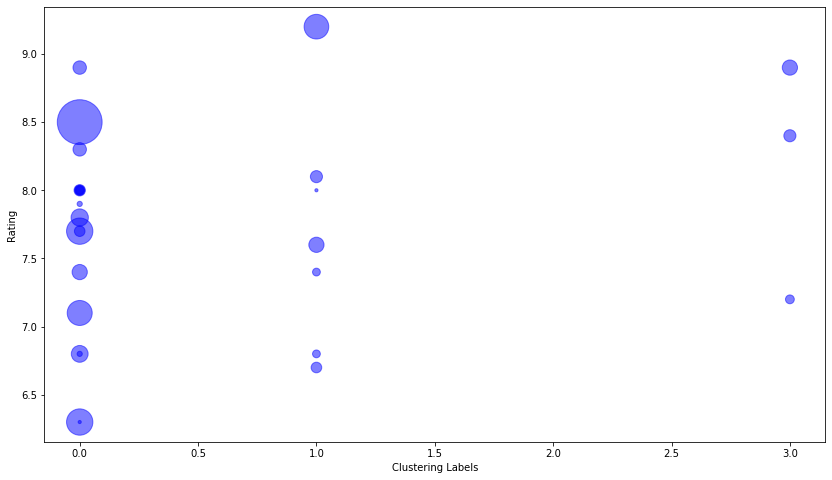

In [38]:
# Normalizing the likes count to use as weights in the bubble plot.
norm_likes =(top_rated_gyms['Likes count'] - top_rated_gyms['Likes count'].min())/(top_rated_gyms['Likes count'].max() - top_rated_gyms['Likes count'].min())

# Plot ratings vs cluster label - The size of the bubbles is proportional to the likes count:
top_rated_gyms.plot(kind='scatter',
                    x='Clustering Labels',
                    y='Rating',
                    figsize=(14, 8),
                    alpha=0.5, # transparency
                    color='blue',
                    s=norm_likes*2000  + 10  # pass in the weights
                    )

## Plotting Rating/Likes Count/Succes metric versus disctances to specific venues

In [61]:
# Function used to compute distances between two latitude and longitude coordinates:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371 # Earth's radius
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [111]:
#Choose a specific venue to use during the analysis of the effect of distance on the rating:
venue_category = 'Pizza Place'

specific_venue = gym_venues_df[gym_venues_df['Categories'] == venue_category]
specific_venue = specific_venue[specific_venue['Rating']!=-1]
specific_venue = specific_venue[specific_venue['Likes count']!=0].reset_index()
norm_likes =(specific_venue['Likes count'] - specific_venue['Likes count'].min())/(specific_venue['Likes count'].max() - specific_venue['Likes count'].min())

In [112]:
columns = ['Rating', 'Distance']
specific_venue_dist= pd.DataFrame(columns=columns)
for index, row in specific_venue.iterrows():
    dist = haversine_distance(row['Gym lat'], row['Gym lng'], row['Lat'], row['Lng'])
    # if dist !=0:
    specific_venue_dist.loc[index] = [row['Rating'],dist]

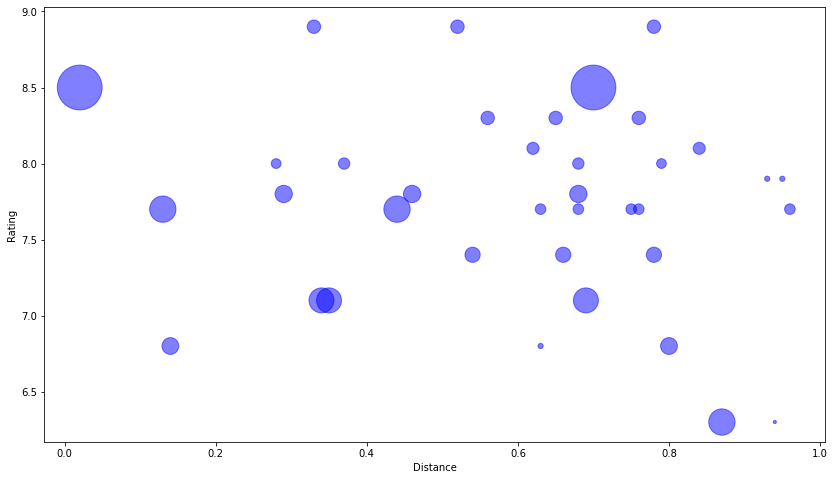

In [113]:
specific_venue_dist.plot(kind='scatter',
                    x='Distance',
                    y='Rating',
                    figsize=(14, 8),
                    alpha=0.5, # transparency
                    color='blue',
                    s=norm_likes*2000  + 10  # pass in the weights
                    )

In [ ]:
# Comments on the analysis of rating = f(distance):
# - See that the more the distance from other gyms/training centers increases rating increases too.

### Ideas for analysis:

In [ ]:
# - Compute distance between each gym and metro station if in nearby venues. Then plot rating/likes count vs distance to metro station
# - Do same analysis for parking

# - Define the criteria that seem to influence the popularity of a training center using the centers that already exist with their ratings (computing distance/proximity to other venues and checking corrolation with rating/likes count)
# - Once some type of criteria is defined we can then look at different neighbourhoods in montreal to see which ones fit the criteria.
# - Find data on the price of rent by location and plot a chloropleth map displaying the data.